In [1]:
import numpy as np

In [2]:
from fluprodia import FluidPropertyDiagram
from CoolProp.CoolProp import PropsSI
import matplotlib.pyplot as plt

In [3]:
fluid = "CH4"

T_min = -150
T_max = -50

dg = FluidPropertyDiagram(fluid)
dg.set_unit_system(T="°C")

In [4]:
dg.set_isolines_subcritical(T_min, T_max)
dg.calc_isolines()

In [5]:
dg.T_min, dg.p_min

(111.50762598454777, 100000.0)

In [6]:
T = PropsSI("T", "Q", 1, "P", dg.p_min, fluid)
PropsSI("P", "Q", 1, "T", dg.T_min, fluid)

dg.pressure["isolines"]
dg.temperature

{'isolines': array([113.15, 133.15, 153.15, 173.15, 193.15, 213.15, 233.15]),
 'style': {'linestyle': '--', 'color': '#363636', 'linewidth': 0.5},
 'label_position': 0.95,
 113.15: {'h': array([514193.31094493, 514186.25083756, 514179.18188557, 514172.10407622,
         514165.01739676, 514157.9218344 , 514150.81737632, 514143.7040097 ,
         514136.58172168, 514129.45049936, 514122.31032984, 514115.16120018,
         514108.00309742, 514100.83600856, 514093.65992061, 514086.47482051,
         514079.2806952 , 514072.07753159, 514064.86531657, 514057.64403698,
         514050.41367967, 514043.17423143, 514035.92567904, 514028.66800925,
         514021.40120879, 514014.12526436, 514006.84016262, 513999.54589022,
         513992.24243378, 513984.92977989, 513977.60791511, 513970.27682598,
         513962.93649901, 513955.58692067, 513948.22807743, 513940.85995571,
         513933.48254191, 513926.0958224 , 513918.69978352, 513911.29441159,
         513903.87969291, 513896.45561372, 51

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


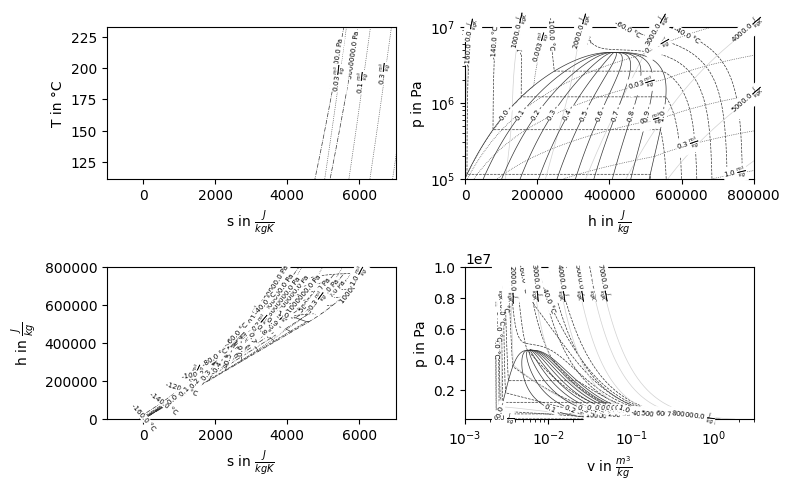

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))

dg.draw_isolines(diagram_type='Ts', fig=fig, ax=ax[0,0], x_min=min(dg.entropy["isolines"]), x_max=max(dg.entropy["isolines"]), y_min=dg.T_min, y_max=dg.T_max)
dg.draw_isolines(diagram_type='logph', fig=fig, ax=ax[0,1], x_min=min(dg.enthalpy["isolines"]), x_max=max(dg.enthalpy["isolines"]), y_min=dg.p_min, y_max=dg.p_max)
dg.draw_isolines(diagram_type='hs', fig=fig, ax=ax[1,0], x_min=min(dg.entropy["isolines"]), x_max=max(dg.entropy["isolines"]), y_min=min(dg.enthalpy["isolines"]), y_max=max(dg.enthalpy["isolines"]))
dg.draw_isolines(diagram_type='plogv', fig=fig, ax=ax[1,1], x_min=min(dg.volume["isolines"]), x_max=max(dg.volume["isolines"]), y_min=dg.p_min, y_max=dg.p_max)

plt.tight_layout()